<a href="https://colab.research.google.com/github/HWaymentSteele/colab_exercises/blob/main/GA_GB_exercise_0928.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMR school 2023, "Interpreting AF2" exercise

Can AF2 correctly predict the structures of the GA88/GB88 proteins?

Also: meet a codebase where it's easier to hack AlphaFold.


- Hit the (play) button to the left to run a cell.

- Questions to answer for the session are in **bold**.


<font size="2"><font color='gray'>Codebase: [ColabDesign](https://github.com/sokrypton/ColabDesign/tree/main) (gamma branch) by Sergey Ovchinnikov

<font size="2"><font color='gray'>Notebook last updated Sept 20 2023, Hannah Wayment-Steele


In [1]:
%%time
#@title setup

import os, time, gc
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@c0d13607c6ee24cb9b93526828c506cfffabc90e")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("installing HHsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading AlphaFold params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)
if "hhsuite" not in os.environ['PATH']:
  os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.shared.protein import _np_rmsd
from colabdesign.shared.parsers import aa2num
from copy import copy

from api import run_mmseqs2
import matplotlib.pyplot as plt
import string
import numpy as np
from sklearn.cluster import DBSCAN

def one_hot(x,cat=None):
  if cat is None: cat = np.max(x)+1
  oh = np.concatenate((np.eye(cat),np.zeros([1,cat])))
  return oh[x]

def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = predict.parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")


installing ColabDesign
installing HHsuite
downloading AlphaFold params
CPU times: user 1.48 s, sys: 928 ms, total: 2.4 s
Wall time: 1min 23s


1. First let's predict the structure of GA88 and go through the building blocks of the ColabDesign code.

In [2]:
# we define our protein sequence as a string.
name='GA88'
seq='TTYKLILNLKQAKEEAIKELVDAGIAEKYIKLIANAKTVEGVWTLKDEILTFTVTE'

#we'll first fetch the msa.
msa, deletion_matrix = predict.get_msa(seq, name, max_msa=4096,
        do_not_filter=True,
        mmseqs2_fn=run_mmseqs2,
        hhfilter_fn=run_hhfilter)

getting unpaired MSA


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]

parsing msas


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

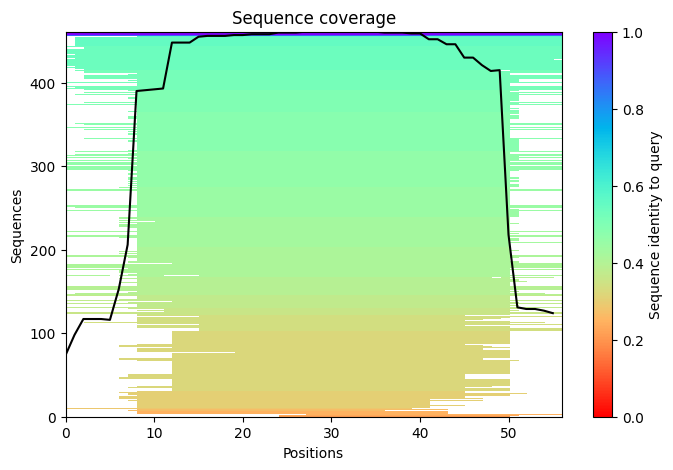

In [3]:
#In the MSA, let's visualize sequence identity to the query and coverage.
predict.plot_msa(msa,[len(seq)])

Now let's initialize AF2 and make a structure prediction using this MSA.

Double click on the below cell to check out the AF2 model getting initialized and setting options.

**What function is initializing the `af2` object?**

After you've taken a look, execute the cell to run predictions with this MSA. (You can double click to hide the code again if you want.)

Note: We're running AF2 with 0 recycles. This is something people do that lets us better evaluate the intrinsic predictive power of AF2. If you're familiar with how AF2 works, think about why.


In [4]:
jobname = "GA88" #@param {type:"string"}
model_type = "auto" #@param ["monomer (ptm)", "multimer (v3)", "auto"]
model = "all" #@param ["1", "2", "3", "4", "5", "all"]
num_recycles = 0 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
recycle_early_stop_tolerance = 0.0 #@param ["0.0", "0.5", "1.0"] {type:"raw"}
use_initial_guess = False
#@markdown MSA options
num_msa = 512 #@param ["1","2","4","8","16","32", "64", "128", "256", "512"] {type:"raw"}
num_extra_msa = 1 #@param ["1","2","4","8","16","32", "64", "128", "256", "512", "1024","2048","4096"] {type:"raw"}
#@markdown Stochastic options
use_dropout = False #@param {type:"boolean"}
seed = 0 #@param {type:"raw"}
num_seeds = 1 #@param ["1", "2", "4", "8", "16", "32", "64", "128"] {type:"raw"}
batches = [None]
copies=1
use_templates=False
u_lengths=[len(seq)]
use_mlm=False

if model_type == "monomer (ptm)":
  use_multimer = False
elif model_type == "multimer (v3)":
  use_multimer = True
elif len(u_lengths) > 1 or copies > 1:
  use_multimer = True
else:
  use_multimer = False

model_opts = {"num_msa":num_msa, # number of sequences to use
              "num_extra_msa":num_extra_msa,
              "num_templates":len(batches),
              "use_mlm":use_mlm,
              "use_cluster_profile":False,
              "use_multimer":use_multimer,
              "use_templates":use_templates,
              "use_batch_as_template":False,
              "use_dgram":True,
              "protocol":"hallucination",
              "best_metric":"pae",
              "optimize_seq":False,
              "debug":False,
              "clear_prev":False}

if "af" in dir():
  if model_opts != model_opts_:
    if model_opts["use_multimer"] == af._args["use_multimer"] \
    or model_opts["use_templates"] == af._args["use_templates"]:
      old_params = dict(zip(af._model_names,
                            af._model_params))
    else:
      print("loading alphafold params")
      old_params = {}
    af = mk_af_model(old_params=old_params,
                     **model_opts)
    model_opts_ = predict.copy_dict(model_opts)
else:
  print("loading alphafold params")
  af = mk_af_model(**model_opts)
  model_opts_ = predict.copy_dict(model_opts)

run_opts = {"seed":seed,
            "use_mlm":use_mlm,
            "use_dropout":use_dropout,
            "num_recycles":num_recycles,
            "model":model,
            "use_initial_guess":use_initial_guess}

af.prep_inputs(u_lengths, copies=copies, seed=seed)

if use_templates:
  af.set_opt(use_initial_guess=use_initial_guess)
  for n,batch in enumerate(batches):
    af.set_template(batch=batch, n=n)
  af.set_opt("template",
             rm_sc=rm_sidechain,
             rm_seq=rm_sequence,
             rm_ic=rm_interchain)
af.set_opt("mlm",
           replace_fraction=0.15 if use_mlm else 0.0)

if model == "all":
  models = af._model_names
else:
  models = [af._model_names[int(model) - 1]]

pdb_path = f"{jobname}/pdb"
os.makedirs(pdb_path, exist_ok=True)

seeds = list(range(seed,seed+num_seeds))
print("running prediction")

outputs=[]

af.set_msa(msa, deletion_matrix)

for seed in seeds:
  af.set_seed(seed)
  for model in models:
    o={}
    recycle = 0
    af._inputs.pop("prev",None)
    stop_recycle = False
    while recycle < num_recycles + 1:
      af.predict(dropout=use_dropout, models=[model], verbose=False)

      print_str = f"{name} seed={seed} model={model} recycle={recycle}"
      print_key = ["plddt","ptm"]
      if len(af._lengths) > 1: print_key.append("i_ptm")
      for k in print_key:
        print_str += f" {k}={af.aux['log'][k]:.3f}"

      af._inputs["prev"] = af.aux["prev"]
      af._save_results(save_best=True, verbose=False)
      af._k += 1

      output_pdb = f"{pdb_path}/{name}_{model}_seed{seed}.pdb"
      af.save_current_pdb(output_pdb)

      recycle += 1
      if recycle > 1:
        rmsd_tol = _np_rmsd(af._tmp["traj"]["xyz"][-2],
                            af._tmp["traj"]["xyz"][-1],
                            use_jax=False)
        if rmsd_tol < recycle_early_stop_tolerance:
          stop_recycle = True
        print_str += f" rmsd_tol={rmsd_tol:.3f}"
      print(print_str)
      if stop_recycle: break

    for k in print_key:
      o.update({k: af.aux['log'][k]})

    o.update({'pdb_path': output_pdb})
    o.update({'model': model})
    o.update({'name': name})
    outputs.append(o)

import pandas as pd
outputs = pd.DataFrame.from_records(outputs)
################
print("GC",gc.collect())

loading alphafold params
running prediction
GA88 seed=0 model=model_1_ptm recycle=0 plddt=0.839 ptm=0.577
GA88 seed=0 model=model_2_ptm recycle=0 plddt=0.822 ptm=0.613
GA88 seed=0 model=model_3_ptm recycle=0 plddt=0.826 ptm=0.586
GA88 seed=0 model=model_4_ptm recycle=0 plddt=0.858 ptm=0.643
GA88 seed=0 model=model_5_ptm recycle=0 plddt=0.821 ptm=0.592
GC 0


In the above code, we made a class that serves as our alphafold model. We can call `af.plot_pdb()` to plot the highest-scoring structure.

In [ ]:
af.plot_pdb()

**Did AF2 correctly predict the structure of GA88?**

Now let's generate a MSA for GB88.

**Do you notice anything in common about the sequence coverage in this MSA and the GA88 MSA?**

In [ ]:
name='GB88'
seq='TTYKLILNLKQAKEEAITEAVDAGTAEKYFKLYANAKTVEGVWTYKDEIKTFTVTE'

msa, deletion_matrix = predict.get_msa(seq, name, max_msa=4096,
        do_not_filter=True,
        mmseqs2_fn=run_mmseqs2,
        hhfilter_fn=run_hhfilter)

predict.plot_msa(msa,[len(seq)])

Now let's make predictions.

In [ ]:
jobname = "GB88" #@param {type:"string"}
model_type = "auto" #@param ["monomer (ptm)", "multimer (v3)", "auto"]
model = "all" #@param ["1", "2", "3", "4", "5", "all"]
num_recycles = 0 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
recycle_early_stop_tolerance = 0.0 #@param ["0.0", "0.5", "1.0"] {type:"raw"}
use_initial_guess = False
#@markdown MSA options
num_msa = 512 #@param ["1","2","4","8","16","32", "64", "128", "256", "512"] {type:"raw"}
num_extra_msa = 1 #@param ["1","2","4","8","16","32", "64", "128", "256", "512", "1024","2048","4096"] {type:"raw"}
#@markdown Stochastic options
use_dropout = False #@param {type:"boolean"}
seed = 0 #@param {type:"raw"}
num_seeds = 1 #@param ["1", "2", "4", "8", "16", "32", "64", "128"] {type:"raw"}
batches = [None]
copies=1
use_templates=False
u_lengths=[len(seq)]
use_mlm=False

if model_type == "monomer (ptm)":
  use_multimer = False
elif model_type == "multimer (v3)":
  use_multimer = True
elif len(u_lengths) > 1 or copies > 1:
  use_multimer = True
else:
  use_multimer = False

model_opts = {"num_msa":num_msa, # number of sequences to use
              "num_extra_msa":num_extra_msa,
              "num_templates":len(batches),
              "use_mlm":use_mlm,
              "use_cluster_profile":False,
              "use_multimer":use_multimer,
              "use_templates":use_templates,
              "use_batch_as_template":False,
              "use_dgram":True,
              "protocol":"hallucination",
              "best_metric":"pae",
              "optimize_seq":False,
              "debug":False,
              "clear_prev":False}

if "af" in dir():
  if model_opts != model_opts_:
    if model_opts["use_multimer"] == af._args["use_multimer"] \
    or model_opts["use_templates"] == af._args["use_templates"]:
      old_params = dict(zip(af._model_names,
                            af._model_params))
    else:
      print("loading alphafold params")
      old_params = {}
    af = mk_af_model(old_params=old_params,
                     **model_opts)
    model_opts_ = predict.copy_dict(model_opts)
else:
  print("loading alphafold params")
  af = mk_af_model(**model_opts)
  model_opts_ = predict.copy_dict(model_opts)

run_opts = {"seed":seed,
            "use_mlm":use_mlm,
            "use_dropout":use_dropout,
            "num_recycles":num_recycles,
            "model":model,
            "use_initial_guess":use_initial_guess}

af.prep_inputs(u_lengths, copies=copies, seed=seed)

if use_templates:
  af.set_opt(use_initial_guess=use_initial_guess)
  for n,batch in enumerate(batches):
    af.set_template(batch=batch, n=n)
  af.set_opt("template",
             rm_sc=rm_sidechain,
             rm_seq=rm_sequence,
             rm_ic=rm_interchain)
af.set_opt("mlm",
           replace_fraction=0.15 if use_mlm else 0.0)

if model == "all":
  models = af._model_names
else:
  models = [af._model_names[int(model) - 1]]

pdb_path = f"{jobname}/pdb"
os.makedirs(pdb_path, exist_ok=True)

seeds = list(range(seed,seed+num_seeds))
print("running prediction")

outputs=[]

af.set_msa(msa, deletion_matrix)

for seed in seeds:
  af.set_seed(seed)
  for model in models:
    o={}
    recycle = 0
    af._inputs.pop("prev",None)
    stop_recycle = False
    while recycle < num_recycles + 1:
      af.predict(dropout=use_dropout, models=[model], verbose=False)

      print_str = f"{name} seed={seed} model={model} recycle={recycle}"
      print_key = ["plddt","ptm"]
      if len(af._lengths) > 1: print_key.append("i_ptm")
      for k in print_key:
        print_str += f" {k}={af.aux['log'][k]:.3f}"

      af._inputs["prev"] = af.aux["prev"]
      af._save_results(save_best=True, verbose=False)
      af._k += 1

      output_pdb = f"{pdb_path}/{name}_{model}_seed{seed}.pdb"
      af.save_current_pdb(output_pdb)

      recycle += 1
      if recycle > 1:
        rmsd_tol = _np_rmsd(af._tmp["traj"]["xyz"][-2],
                            af._tmp["traj"]["xyz"][-1],
                            use_jax=False)
        if rmsd_tol < recycle_early_stop_tolerance:
          stop_recycle = True
        print_str += f" rmsd_tol={rmsd_tol:.3f}"
      print(print_str)
      if stop_recycle: break

    for k in print_key:
      o.update({k: af.aux['log'][k]})

    o.update({'pdb_path': output_pdb})
    o.update({'model': model})
    o.update({'name': name})
    outputs.append(o)

import pandas as pd
outputs = pd.DataFrame.from_records(outputs)
################
print("GC",gc.collect())

running prediction
GB88 seed=0 model=model_1_ptm recycle=0 plddt=0.614 ptm=0.422
GB88 seed=0 model=model_2_ptm recycle=0 plddt=0.658 ptm=0.449
GB88 seed=0 model=model_3_ptm recycle=0 plddt=0.636 ptm=0.428
GB88 seed=0 model=model_4_ptm recycle=0 plddt=0.627 ptm=0.427
GB88 seed=0 model=model_5_ptm recycle=0 plddt=0.524 ptm=0.341
GC 12


In [ ]:
#Let's check out the top-scoring model from GB88:

af.plot_pdb()

**Did AF2 correctly predict the structure of GB88?**

Let's see what happens if we modify the GB88 MSA that we give AF2. We're going to use a filtering step to filter out sequences that are less similar to GB88. Below, the only change from before is that we're setting `do_not_filter=False`.

In [ ]:
name='GB88'
seq='TTYKLILNLKQAKEEAITEAVDAGTAEKYFKLYANAKTVEGVWTYKDEIKTFTVTE'

msa, deletion_matrix = predict.get_msa(seq, name, max_msa=4096,
        do_not_filter=False,
          id=99, #max sequence identity to query is 99
          qid=60, # min sequence identity to query is 60
        mmseqs2_fn=run_mmseqs2,
        hhfilter_fn=run_hhfilter)

predict.plot_msa(msa,[len(seq)])

**How do you think predictions from this filtered MSA might change AF2's prediction for GB88? Why?**

Let's give it a spin:

In [ ]:
jobname = "GB88_filtered_MSA" #@param {type:"string"}
model_type = "auto" #@param ["monomer (ptm)", "multimer (v3)", "auto"]
model = "all" #@param ["1", "2", "3", "4", "5", "all"]
num_recycles = 0 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
recycle_early_stop_tolerance = 0.0 #@param ["0.0", "0.5", "1.0"] {type:"raw"}
use_initial_guess = False
#@markdown MSA options
num_msa = 512 #@param ["1","2","4","8","16","32", "64", "128", "256", "512"] {type:"raw"}
num_extra_msa = 1 #@param ["1","2","4","8","16","32", "64", "128", "256", "512", "1024","2048","4096"] {type:"raw"}
#@markdown Stochastic options
use_dropout = False #@param {type:"boolean"}
seed = 0 #@param {type:"raw"}
num_seeds = 1 #@param ["1", "2", "4", "8", "16", "32", "64", "128"] {type:"raw"}
batches = [None]
copies=1
use_templates=False
u_lengths=[len(seq)]
use_mlm=False

if model_type == "monomer (ptm)":
  use_multimer = False
elif model_type == "multimer (v3)":
  use_multimer = True
elif len(u_lengths) > 1 or copies > 1:
  use_multimer = True
else:
  use_multimer = False

model_opts = {"num_msa":num_msa, # number of sequences to use
              "num_extra_msa":num_extra_msa,
              "num_templates":len(batches),
              "use_mlm":use_mlm,
              "use_cluster_profile":False,
              "use_multimer":use_multimer,
              "use_templates":use_templates,
              "use_batch_as_template":False,
              "use_dgram":True,
              "protocol":"hallucination",
              "best_metric":"pae",
              "optimize_seq":False,
              "debug":False,
              "clear_prev":False}

if "af" in dir():
  if model_opts != model_opts_:
    if model_opts["use_multimer"] == af._args["use_multimer"] \
    or model_opts["use_templates"] == af._args["use_templates"]:
      old_params = dict(zip(af._model_names,
                            af._model_params))
    else:
      print("loading alphafold params")
      old_params = {}
    af = mk_af_model(old_params=old_params,
                     **model_opts)
    model_opts_ = predict.copy_dict(model_opts)
else:
  print("loading alphafold params")
  af = mk_af_model(**model_opts)
  model_opts_ = predict.copy_dict(model_opts)

run_opts = {"seed":seed,
            "use_mlm":use_mlm,
            "use_dropout":use_dropout,
            "num_recycles":num_recycles,
            "model":model,
            "use_initial_guess":use_initial_guess}

af.prep_inputs(u_lengths, copies=copies, seed=seed)

if use_templates:
  af.set_opt(use_initial_guess=use_initial_guess)
  for n,batch in enumerate(batches):
    af.set_template(batch=batch, n=n)
  af.set_opt("template",
             rm_sc=rm_sidechain,
             rm_seq=rm_sequence,
             rm_ic=rm_interchain)
af.set_opt("mlm",
           replace_fraction=0.15 if use_mlm else 0.0)

if model == "all":
  models = af._model_names
else:
  models = [af._model_names[int(model) - 1]]

pdb_path = f"{jobname}/pdb"
os.makedirs(pdb_path, exist_ok=True)

seeds = list(range(seed,seed+num_seeds))
print("running prediction")

outputs=[]

af.set_msa(msa, deletion_matrix)

for seed in seeds:
  af.set_seed(seed)
  for model in models:
    o={}
    recycle = 0
    af._inputs.pop("prev",None)
    stop_recycle = False
    while recycle < num_recycles + 1:
      af.predict(dropout=use_dropout, models=[model], verbose=False)

      print_str = f"{name} seed={seed} model={model} recycle={recycle}"
      print_key = ["plddt","ptm"]
      if len(af._lengths) > 1: print_key.append("i_ptm")
      for k in print_key:
        print_str += f" {k}={af.aux['log'][k]:.3f}"

      af._inputs["prev"] = af.aux["prev"]
      af._save_results(save_best=True, verbose=False)
      af._k += 1

      output_pdb = f"{pdb_path}/{name}_{model}_seed{seed}.pdb"
      af.save_current_pdb(output_pdb)

      recycle += 1
      if recycle > 1:
        rmsd_tol = _np_rmsd(af._tmp["traj"]["xyz"][-2],
                            af._tmp["traj"]["xyz"][-1],
                            use_jax=False)
        if rmsd_tol < recycle_early_stop_tolerance:
          stop_recycle = True
        print_str += f" rmsd_tol={rmsd_tol:.3f}"
      print(print_str)
      if stop_recycle: break

    for k in print_key:
      o.update({k: af.aux['log'][k]})

    o.update({'pdb_path': output_pdb})
    o.update({'model': model})
    o.update({'name': name})
    outputs.append(o)

import pandas as pd
outputs = pd.DataFrame.from_records(outputs)
################
print("GC",gc.collect())

running prediction
GB88 seed=0 model=model_1_ptm recycle=0 plddt=0.590 ptm=0.412
GB88 seed=0 model=model_2_ptm recycle=0 plddt=0.713 ptm=0.478
GB88 seed=0 model=model_3_ptm recycle=0 plddt=0.623 ptm=0.418
GB88 seed=0 model=model_4_ptm recycle=0 plddt=0.675 ptm=0.477
GB88 seed=0 model=model_5_ptm recycle=0 plddt=0.552 ptm=0.375
GC 12


In [ ]:
af.plot_pdb()

**Did AF2 correctly predict the structure of GB88 with the second MSA?**

**Were you correct in your prediction about AF2?**

Bonus: check out the other attributes of the `af` object. What does `af.animate()` do?

For aficionados: this is the same object used in ColabDesign, so this is all the code one needs to try out protein design too! For our purposes here, we won't be using it in design mode (i.e., `optimize_seq=False`, and other things, to not do backprop). for more on ColabDesign, check out [this demo notebook](https://colab.research.google.com/github/sokrypton/ColabDesign/blob/v1.1.1/af/design.ipynb).

# Part III: How well (or poorly) does pLDDT approximate thermodynamics in this system?

In Alexander et al. (2009), the authors identify 6 sets of mutations between GA88 and GB88 that vary in their folds and stability, characterized by melting temperature. Notably, they find that only one point mutation can flip the structure!

| Construct | Sequence | Fold | Tm (˚C) | dG @ 20˚C (kcal/mol) |
| ---- |  ---- |  ---- |  ---- | ---- |
|GA77 | `TTYKLILNLKQAKEEAIKELVDAGIAEKYIKLIANAKTVEGVWTLKDEILKATVTE` | GA | 77.5| 5 |
|GA88 | `TTYKLILNLKQAKEEAIKELVDAGIAEKYIKLIANAKTVEGVWTLKDEILTFTVTE` | GA | 69.4| 4.9* |
|GA91 | `TTYKLILNLKQAKEEAIKELVDAGTAEKYIKLIANAKTVEGVWTLKDEILTFTVTE` | GA | 61.5| >3 |
|GA95 | `TTYKLILNLKQAKEEAIKELVDAGTAEKYIKLIANAKTVEGVWTLKDEIKTFTVTE` | GA | 50.0| 3 |
|GA98 | `TTYKLILNLKQAKEEAIKELVDAGTAEKYFKLIANAKTVEGVWTLKDEIKTFTVTE` | GA | 37.0| 1.7* |
|GB98 | `TTYKLILNLKQAKEEAIKELVDAGTAEKYFKLIANAKTVEGVWTYKDEIKTFTVTE` | GB | 35.0| 1.5* |
|GB95 | `TTYKLILNLKQAKEEAIKEAVDAGTAEKYFKLIANAKTVEGVWTYKDEIKTFTVTE` | GB | 48.7| 3 |
|GB91 | `TTYKLILNLKQAKEEAIKEAVDAGTAEKYFKLYANAKTVEGVWTYKDEIKTFTVTE` | GB | 49.3| >3 |
|GB88 | `TTYKLILNLKQAKEEAITEAVDAGTAEKYFKLYANAKTVEGVWTYKDEIKTFTVTE` | GB | 57.5| 3.8* |
|GB77 | `TTYKLILNGKQLKEEAITEAVDAATAEKYFKLYANAKTVEGVWTYKDETKTFTVTE` | GB | 62.4| 5 |

*interpolated from reported values, assuming $\Delta S_\text{unfold}$ is constant.

In this next part, we're going to explore how well (or poorly) AF2 predicts the folds of these structures, and the change in pLDDT predicts the measured changes in $\Delta G$'s.

---

First we're going to create 2 MSAs, based on the WT GA and GB sequences, and use these as input to fold all the series of point mutations.


In [ ]:
seqs = {
'GA77':	'TTYKLILNLKQAKEEAIKELVDAGIAEKYIKLIANAKTVEGVWTLKDEILKATVTE',
'GA88':	'TTYKLILNLKQAKEEAIKELVDAGIAEKYIKLIANAKTVEGVWTLKDEILTFTVTE',
'GA91':	'TTYKLILNLKQAKEEAIKELVDAGTAEKYIKLIANAKTVEGVWTLKDEILTFTVTE',
'GA95':	'TTYKLILNLKQAKEEAIKELVDAGTAEKYIKLIANAKTVEGVWTLKDEIKTFTVTE',
'GA98':	'TTYKLILNLKQAKEEAIKELVDAGTAEKYFKLIANAKTVEGVWTLKDEIKTFTVTE',
'GB98':	'TTYKLILNLKQAKEEAIKELVDAGTAEKYFKLIANAKTVEGVWTYKDEIKTFTVTE',
'GB95':	'TTYKLILNLKQAKEEAIKEAVDAGTAEKYFKLIANAKTVEGVWTYKDEIKTFTVTE',
'GB91':	'TTYKLILNLKQAKEEAIKEAVDAGTAEKYFKLYANAKTVEGVWTYKDEIKTFTVTE', # note there's a typo in Fig. 2 PNAS 2009.
'GB88':	'TTYKLILNLKQAKEEAITEAVDAGTAEKYFKLYANAKTVEGVWTYKDEIKTFTVTE',
'GB77':	'TTYKLILNGKQLKEEAITEAVDAATAEKYFKLYANAKTVEGVWTYKDETKTFTVTE',
         }

First set up the af model again:

In [ ]:
jobname = "GA_GB_mutant_series" #@param {type:"string"}
model_type = "auto" #@param ["monomer (ptm)", "multimer (v3)", "auto"]
model = "1" #@param ["1", "2", "3", "4", "5", "all"]
num_recycles = 0 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
recycle_early_stop_tolerance = 0.0 #@param ["0.0", "0.5", "1.0"] {type:"raw"}
use_initial_guess = False
#@markdown MSA options
num_msa = 512 #@param ["1","2","4","8","16","32", "64", "128", "256", "512"] {type:"raw"}
num_extra_msa = 1 #@param ["1","2","4","8","16","32", "64", "128", "256", "512", "1024","2048","4096"] {type:"raw"}
#@markdown Stochastic options
use_dropout = False #@param {type:"boolean"}
seed = 0 #@param {type:"raw"}
num_seeds = 1 #@param ["1", "2", "4", "8", "16", "32", "64", "128"] {type:"raw"}
batches = [None]
copies=1
use_templates=False
u_lengths=[len(seq)]
use_mlm=False

if model_type == "monomer (ptm)":
  use_multimer = False
elif model_type == "multimer (v3)":
  use_multimer = True
elif len(u_lengths) > 1 or copies > 1:
  use_multimer = True
else:
  use_multimer = False

model_opts = {"num_msa":num_msa, # number of sequences to use
              "num_extra_msa":num_extra_msa,
              "num_templates":len(batches),
              "use_mlm":use_mlm,
              "use_cluster_profile":False,
              "use_multimer":use_multimer,
              "use_templates":use_templates,
              "use_batch_as_template":False,
              "use_dgram":True,
              "protocol":"hallucination",
              "best_metric":"pae",
              "optimize_seq":False,
              "debug":False,
              "clear_prev":False}

if "af" in dir():
  if model_opts != model_opts_:
    if model_opts["use_multimer"] == af._args["use_multimer"] \
    or model_opts["use_templates"] == af._args["use_templates"]:
      old_params = dict(zip(af._model_names,
                            af._model_params))
    else:
      print("loading alphafold params")
      old_params = {}
    af = mk_af_model(old_params=old_params,
                     **model_opts)
    model_opts_ = predict.copy_dict(model_opts)
else:
  print("loading alphafold params")
  af = mk_af_model(**model_opts)
  model_opts_ = predict.copy_dict(model_opts)

run_opts = {"seed":seed,
            "use_mlm":use_mlm,
            "use_dropout":use_dropout,
            "num_recycles":num_recycles,
            "model":model,
            "use_initial_guess":use_initial_guess}

af.prep_inputs(u_lengths, copies=copies, seed=seed)

if use_templates:
  af.set_opt(use_initial_guess=use_initial_guess)
  for n,batch in enumerate(batches):
    af.set_template(batch=batch, n=n)
  af.set_opt("template",
             rm_sc=rm_sidechain,
             rm_seq=rm_sequence,
             rm_ic=rm_interchain)
af.set_opt("mlm",
           replace_fraction=0.15 if use_mlm else 0.0)

if model == "all":
  models = af._model_names
else:
  models = [af._model_names[int(model) - 1]]

pdb_path = f"{jobname}/pdb"
os.makedirs(pdb_path, exist_ok=True)

In [ ]:
#fetch the msas:

GA_WT='MEAVDANSLAQAKEAAIKELKQYGIGDYYIKLINNAKTVEGVESLKNEILKALPTE'
GB_WT='MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'

# Fetch the GA MSA:
msa_A, dtx_A = predict.get_msa(GA_WT, 'GAWT', max_msa=4096,
        do_not_filter=True,
        mmseqs2_fn=run_mmseqs2,
        hhfilter_fn=run_hhfilter)

##### TODO: fetch the GB MSA #####

##################################

model=1
seed=0
outputs=[]

##### TODO: Modify the below code to also loop through the GA and GB MSA #####

for name, seq in seqs.items():
  msa_list = [msa_A]
  dtx_list = [dtx_A]
  msa_names = ['GA_MSA']

  for i in range(len(msa_list)):

    local_msa = copy(msa_list[i])
    local_msa[0] = aa2num(seq) # updates the first sequence to be the one we want.

    af.set_msa(local_msa, dtx_list[i])
    af.set_seed(seed)
    o={}

    recycle=0
    af._inputs.pop("prev",None)
    stop_recycle = False
    while recycle < num_recycles + 1:
      af.predict(dropout=use_dropout, models=[model], verbose=False)

      print_str = f"MSA={msa_names[i]} {name} seed={seed} model={model} recycle={recycle}"
      print_key = ["plddt","ptm"]
      if len(af._lengths) > 1: print_key.append("i_ptm")
      for k in print_key:
        print_str += f" {k}={af.aux['log'][k]:.3f}"

      af._inputs["prev"] = af.aux["prev"]
      af._save_results(save_best=True, verbose=False)
      af._k += 1

      output_pdb = f"{pdb_path}/{msa_names[i]}_{name}_{model}_seed{seed}.pdb"
      af.save_current_pdb(output_pdb)

      recycle += 1
      if recycle > 1:
        rmsd_tol = _np_rmsd(af._tmp["traj"]["xyz"][-2],
                            af._tmp["traj"]["xyz"][-1],
                            use_jax=False)
        if rmsd_tol < recycle_early_stop_tolerance:
          stop_recycle = True
        print_str += f" rmsd_tol={rmsd_tol:.3f}"
      print(print_str)
      if stop_recycle: break

    for k in print_key:
      o.update({k: af.aux['log'][k]})

    o.update({'MSA': msa_names[i]})
    o.update({'sequence': name})
    o.update({'exp_dG': dG[name]})
    outputs.append(o)

import pandas as pd
outputs = pd.DataFrame.from_records(outputs)
################
print("GC",gc.collect())

In [ ]:
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')

# the outputs of the runs is stored in a dataframe named "outputs". We're going to use it to check out the pLDDTs of the mutants.
### Compare the pLDDTs for each variant using the MSA from both the GA and the GB MSA.
### Google how to do a barplot in seaborn if you're not familiar.

Is this what you expect? Does the pLDDT for the correct structure mirror $\Delta G(20˚C)$ ?